__Data Scientist:__ Gail Wittich <br>__Email:__ gwittich@optusnet.com.au <br>__Website:__ www.linkedin.com/in/gail-wittich-7709b4a <br> __Copyright__ : 'Copyright 2020, Gail Wittich'

## Salary Prediction Project - Modeling
This script loads data, builds and tests several predictive models, engineers new features, creates and validates several predictive models, selects the best one, fits it, makes predictions and scores the models results, summarises results and saves them using the salary prediction datasets.

EDA was performed in a seperate script, SalaryPredictionEDA.ipynb.

IT DOES NOT include deployment activities (pipeline automation, solution deployment or measurement of efficacy).

### Import packages

In [1]:
#!/usr/bin/env python3
   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

### Define Data class

In [2]:
class Data:
    def __init__(self, train_file, test_file, categorical_cols, numeric_cols, target_col, key):
        # create train and test dataframes
        # create new copies instead of references
        self.categorical_cols = list(categorical_cols)
        self.numeric_cols = list(numeric_cols)
        self.feature_cols = categorical_cols + numeric_cols
        self.target_col = target_col
        self.key = key
        self.label_encoders = {}
        self.train_df = self._create_train_df(train_file)
        self.test_df = self._create_test_df(test_file)
        self.results_df = pd.DataFrame(self.test_df)
    
    def label_encode_df(self, df, cols):
        # creates one label encoder (convert object data to numeric data) for each column in the data frame
        for col in cols:
            if col in self.label_encoders:
                # if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)

    def _label_encode(self, df, col, le=None):
        # label encodes data
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le

    def _create_train_df(self, train_df, label_encode=True):
        # loads and merges training data features and targets, preprocesses data, encodes data
        train_df = self._load_data(train_file)
        if label_encode:
            self.label_encode_df(train_df, self.categorical_cols)
        return train_df

    def _create_test_df(self, test_file, label_encode=True):
        # loads and label encodes test data
        test_df = self._load_data(test_file)
        if label_encode:
            self.label_encode_df(test_df, self.categorical_cols)
        return test_df

    def _load_data(self, file):
        return pd.read_csv(file)

### Define FeatureGenerator class

In [3]:
class FeatureGenerator:
    def __init__(self, data):
        # initializes class and creates groupby object for data
        self.data = data
        # able to generate features for new companies, but less accurate
        self.categorical_cols = data.categorical_cols
        self.groups = data.train_df.groupby(self.categorical_cols)
        
    def add_group_stats(self):
        # adds group statistics to data stored in data object
        # get group stats
        group_stats_df = self._get_group_stats()
        group_stats_df.reset_index(inplace=True)

        # merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.categorical_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.categorical_cols, fillna=True)

        # update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, categorical_cols=group_stats_cols)

    def _get_group_stats(self):
        # calculates group statistics
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df

    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        # merges engineered features with original df
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df

    def _extend_col_lists(self, data, categorical_cols=[], numeric_cols=[]):
        # addes engineered feature cols to data col lists
        data.numeric_cols.extend(numeric_cols)
        data.categorical_cols.extend(categorical_cols)
        data.feature_cols.extend(numeric_cols + categorical_cols)

### Define ModelContainer class

In [4]:
class ModelContainer:
    def __init__(self, models=[]):  # default_num_iters=10, verbose_lvl=0):
        # initializes model list and dicts
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        
    def add_model(self, model):
        self.models.append(model)
   
    def cross_validate(self, data, k=5):  
        # cross validate models using given data
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0 * np.mean(neg_mse)

    def select_best_model(self):
        # select model with lowest mse
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        # fits best model
        self.best_model.fit(features, targets)

    def best_model_predict(self, features):
        # scores features using best model
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        # save predictions to .csv file
        data.results_df['predictedSalary'] = self.predictions.tolist()
        data.results_df[['jobId', 'predictedSalary']].to_csv('data/results_salaries.csv', index = False)
        # save best model to pickle file
        with open('data/salary_predict_model.pkl', 'wb') as temp:
            pickle.dump(models.best_model, temp)

    @staticmethod
    def get_feature_importance(model, cols):
        # retrieves and sorts feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature': cols, 'importance': importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            # set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            # some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        # prints summary of models, best model, and feature importance
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))                                                                                   
        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()

### Run Modelling


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) - MSE: 358.1687192147954

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) - MSE: 313.01349021394435

 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_sa

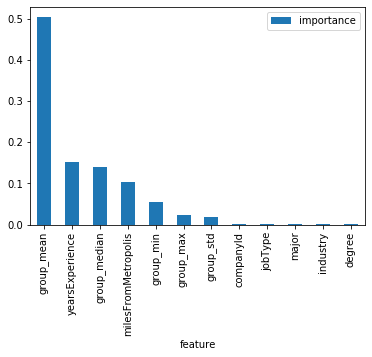

In [5]:
if __name__ == '__main__':
    # set verbose level for models
    verbose_lvl = 0

    # define input files
    train_file = 'data/salaryPredictEDA.csv'
    # train_target_file = 'data/train_salaries.csv'
    test_file = 'data/test_features.csv'

    # define variables
    categorical_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_cols = ['yearsExperience', 'milesFromMetropolis']
    target_col = 'salary'
    key = 'jobId'

    # turn feature engineering on/off
    engineer_features = True

    # Create data object
    data = Data(train_file, test_file, categorical_cols, numeric_cols, target_col, key)

    # Engineer features
    if engineer_features:
        feature_generator = FeatureGenerator(data)
        feature_generator.add_group_stats()

    # create model container
    models = ModelContainer()

    # create models -hyperparameter tuning already done by hand for each model
    models.add_model(LinearRegression())
    models.add_model(RandomForestRegressor(n_estimators=60, max_depth=15, min_samples_split=80,
                                           max_features=8, verbose=verbose_lvl))    
    models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))

    # Cross validate models, then select, fit, and score test data with best model
    models.cross_validate(data, k=5)
    models.select_best_model()
    models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
    models.best_model_predict(data.test_df[data.feature_cols])
    
    # Summarize results
    models.print_summary()
    
    # Save results
    models.save_results()